In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_auc_score, auc, roc_curve,f1_score, mutual_info_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, MaxPooling2D, UpSampling2D


In [2]:
data = pd.read_csv('data.csv')
# уберем фичи, которые не используются для задания 
unused_features = ['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1',
                   'coeff_sum0', 'coeff_sum1']
data.drop(columns=unused_features, inplace=True)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


In [4]:
def analysis(data: pd.DataFrame):
    # общая инфомарция 
    print("Типы данных в датасете:")
    data.info()
    print("-----------------------------------------------")
    print("Основные характеристики данных:", data.describe(), sep='\n')
    print("-----------------------------------------------")
    print(f"Данные были собраны с {str(pd.to_datetime(data['date_time']).min().date())} по {str(pd.to_datetime(data['date_time']).max().date())}")
    print("-----------------------------------------------")
    print("Рассмотрим, сколько уникальных значений есть в каждом признаке")
    print(data.drop(columns='date_time').nunique())
    print("-----------------------------------------------")
    print(f"Количество повторяющихся значений признаков: {len(data[data.duplicated()])}")
    print(f"Количество нулевых значений признаков: {data.isna().sum().sum()}")
    
    data_day_only = pd.to_datetime(data['date_time']).dt.date

    ### UPD1: Построим частоту каждой даты, чтобы увидеть как данные распределяются по дням
    plt.figure(figsize=(10, 6))
    data_day_only.value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title('Частота уникальных дат')
    plt.xlabel('Дата')
    plt.ylabel('Частота')
    plt.show()

    # матрица корреляций
    correlation_matrix = data.drop(columns='date_time').corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm").set(title='Матрица корреляций')
    print("-----------------------------------------------")
    print("Рассмотрим матрицу корреляций:")
    plt.show()
    
    # UPD: у пар (zone_id, country_id), (country_id, campaign_clicks) и (zone_id, campaign_clicks) 
    # наибольшая корреляция в таблице корреляций (>0.059). Рассмотрим их интеракции 

    print("Для zone_id и country_id используем Mutual Information Score")
    mi_score = mutual_info_score(data['country_id'], data['zone_id'])
    print(f"Mutual Information Score: {mi_score}")
    
    sns.scatterplot(x='country_id', y='campaign_clicks', data=data)
    plt.title('Scatter Plot of Country ID vs Zone ID')
    plt.xlabel('Country ID')
    plt.ylabel('Сampaign Сlicks')
    plt.show()
    
    sns.scatterplot(x='zone_id', y='campaign_clicks', data=data)
    plt.title('Scatter Plot of Country ID vs Zone ID')
    plt.xlabel('Zone ID')
    plt.ylabel('Сampaign Сlicks')
    plt.show()
    
    
    # распределение фич 
    print("-----------------------------------------------")
    print("Рассмотрим распределение признаков:")
    for i in data.drop(columns='date_time').columns:
        plt.figure(figsize=(10, 6))
        plt.hist(data[i], bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Распределение значений в столбце "{i}"')
        plt.xlabel(f'Значение {i}')
        plt.ylabel('Частота')
        plt.show()
    
    # рассмотрим отдельно распределение zone_id, campaign_clicks, banner_id, 
    # т.к. у них наибольшее количество уникальных значений
    print("-----------------------------------------------")
    print("Рассмотрим распределение campaign_clicks, zone_id и banner_id:")  
    print("кол-во уникальных значений в banner_id:", data['banner_id'].value_counts(), sep='\n')
    print("кол-во уникальных значений в zone_id:", data['zone_id'].value_counts(), sep='\n')
    print("кол-во уникальных значений в campaign_clicks:", data['campaign_clicks'].value_counts(), sep='\n')


Типы данных в датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15821472 entries, 0 to 15821471
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date_time              object 
 1   zone_id                int64  
 2   banner_id              int64  
 3   campaign_clicks        int64  
 4   os_id                  int64  
 5   country_id             int64  
 6   impressions            int64  
 7   clicks                 int64  
 8   clicks_per_impression  float64
dtypes: float64(1), int64(7), object(1)
memory usage: 1.1+ GB
-----------------------------------------------
Основные характеристики данных:
            zone_id     banner_id  campaign_clicks         os_id   
count  1.582147e+07  1.582147e+07     1.582147e+07  1.582147e+07  \
mean   8.152679e+01  3.816483e+02     6.238540e-01  1.840605e+00   
std    1.632448e+02  3.959386e+02     9.249152e+00  1.530005e+00   
min    0.000000e+00  0.000000e+00     0.000000e+00  

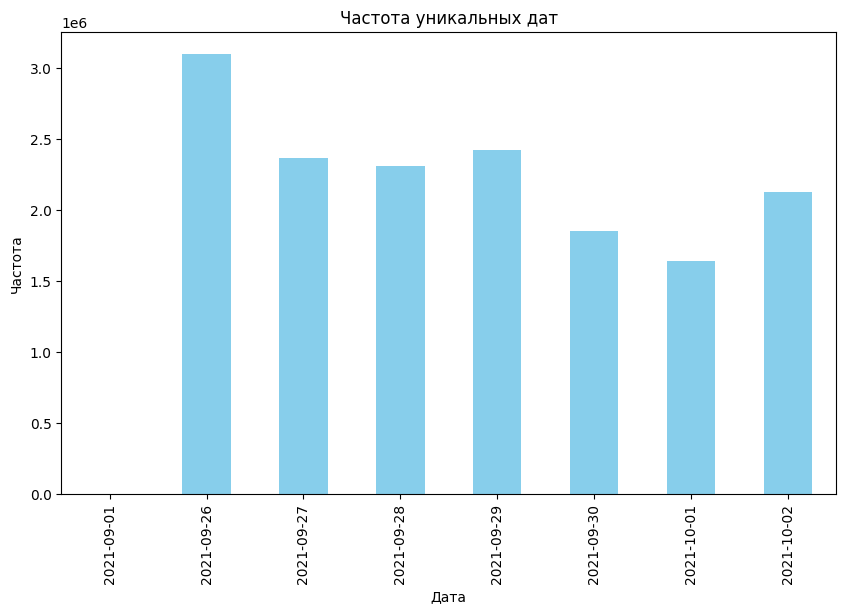

-----------------------------------------------
Рассмотрим матрицу корреляций:


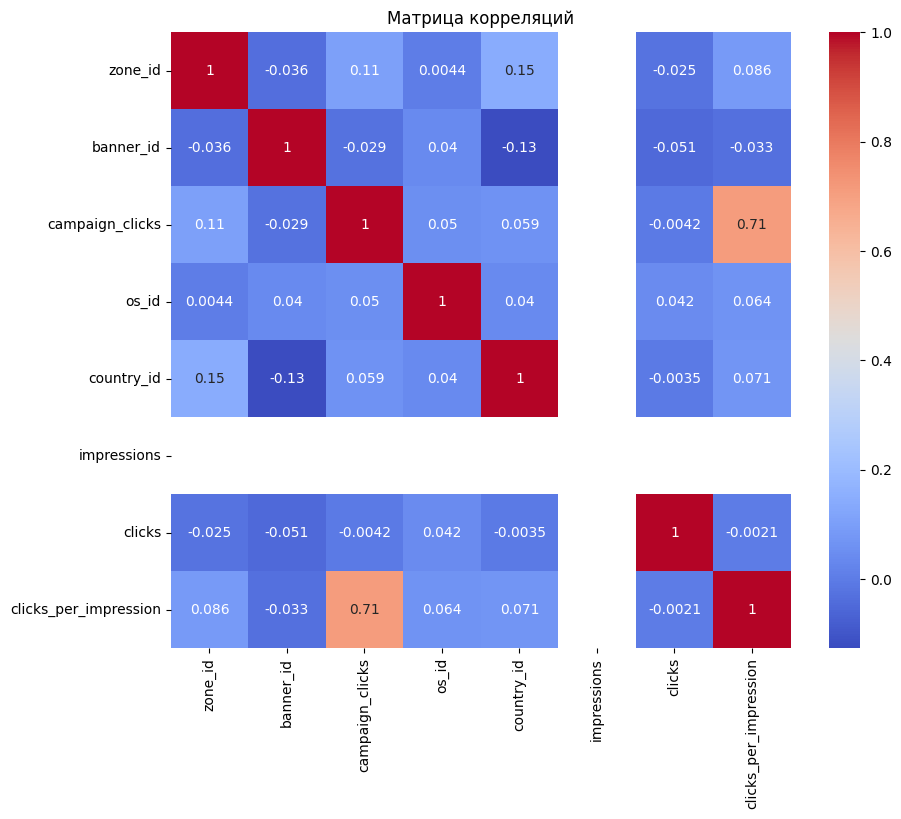

Для zone_id и country_id используем Mutual Information Score
Mutual Information Score: 0.71175965458153


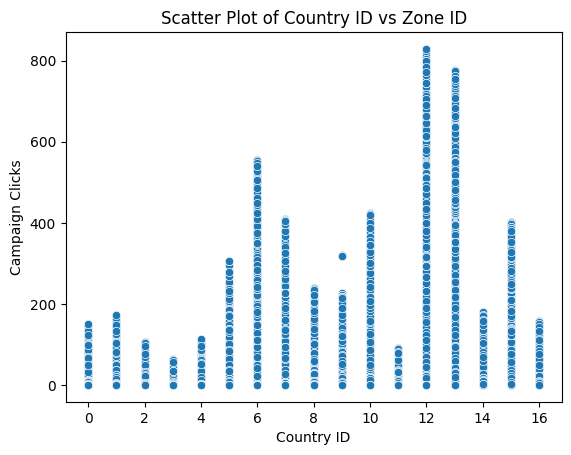

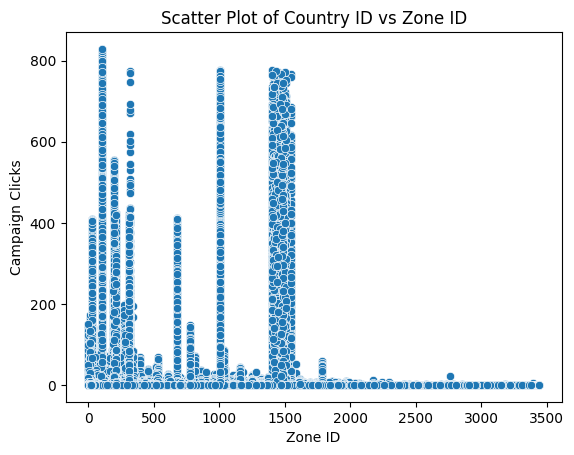

-----------------------------------------------
Рассмотрим распределение признаков:


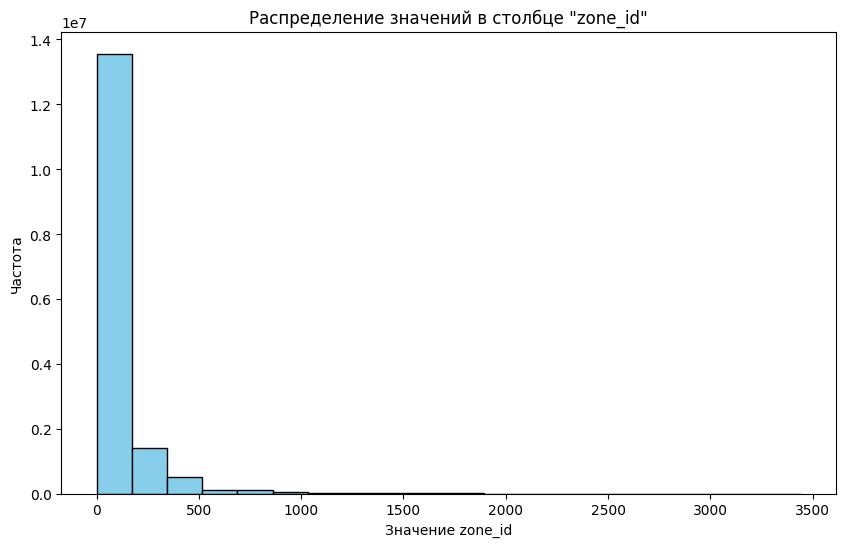

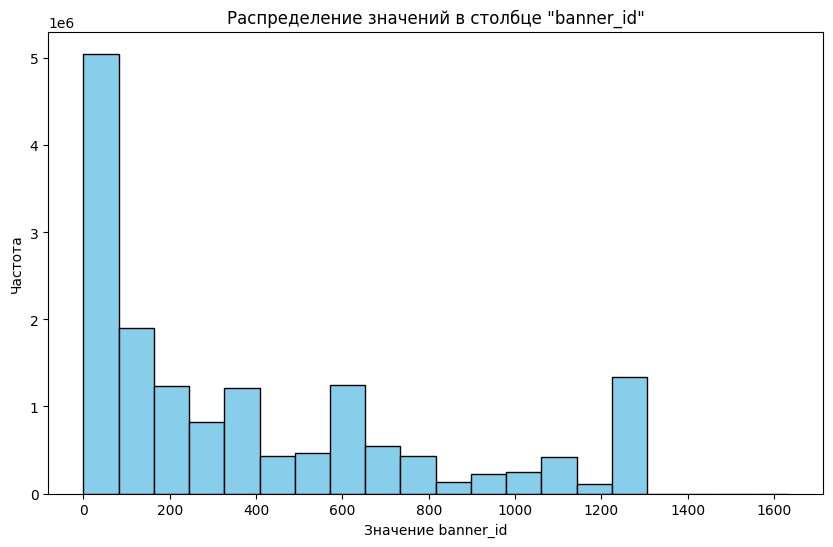

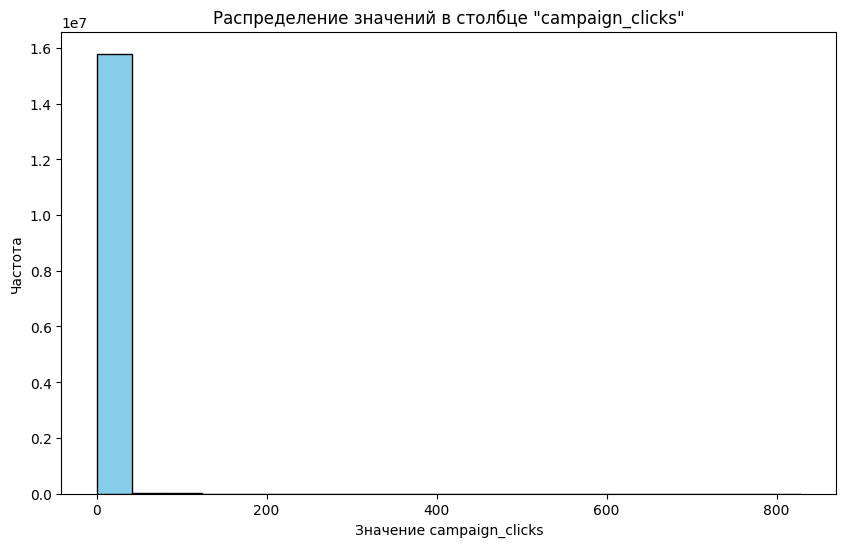

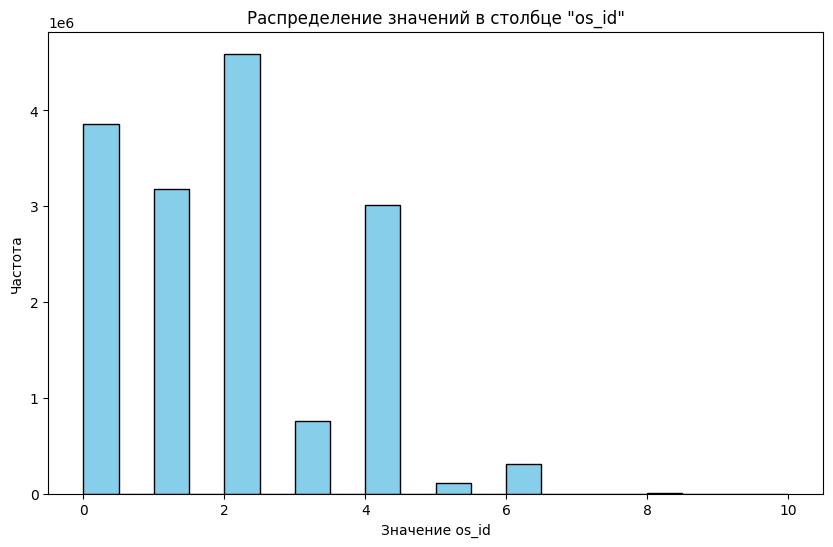

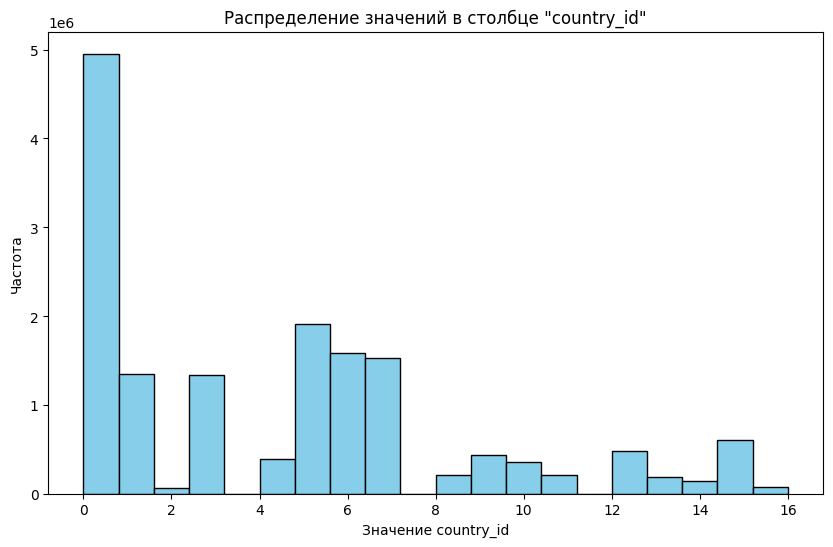

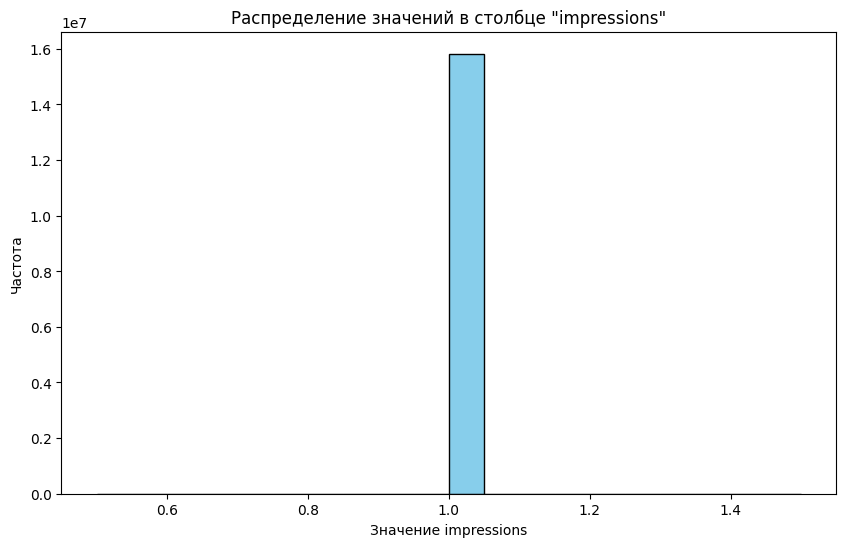

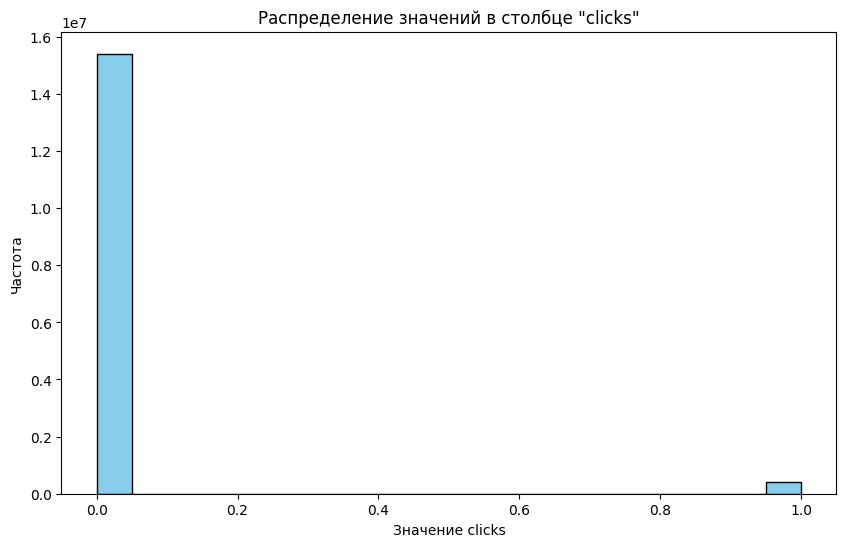

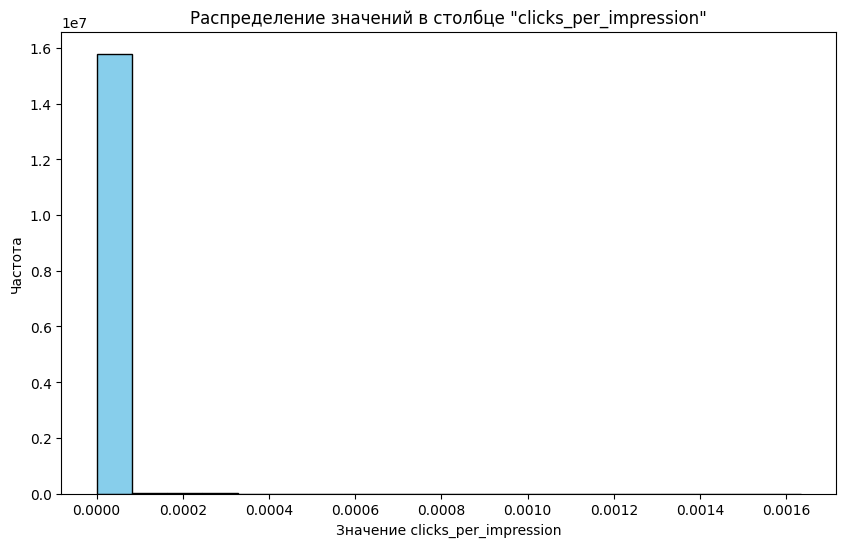

-----------------------------------------------
Рассмотрим распределение campaign_clicks, zone_id и banner_id:
кол-во уникальных значений в banner_id:
banner_id
22      613367
361     387563
3       286999
18      262946
21      246378
         ...  
1501         1
1503         1
1504         1
1507         1
1632         1
Name: count, Length: 1633, dtype: int64
кол-во уникальных значений в zone_id:
zone_id
17      2280422
14      1638642
12       736352
0        708379
19       693292
         ...   
2186          1
2188          1
2518          1
2962          1
3443          1
Name: count, Length: 3444, dtype: int64
кол-во уникальных значений в campaign_clicks:
campaign_clicks
0      13682452
1       1236822
2        342937
3        173528
4        100293
         ...   
791           1
829           1
820           1
803           1
828           1
Name: count, Length: 822, dtype: int64


In [5]:
analysis(data)

# Выводы анализа: 
1. cтолбец "impressions" полностью состоит из единиц, следовательно, не несет никакой информации;
2. в данных имеются дубликаты; 
3. столбец "date_time" имеет неверный формат. Его нужно перевести в правильный формат и разбить на несколько измерений: часы, часть суток, день недели - так он будет более информативным;
4. между признаками нет явной корреляции как друг с другом, так и с целевой переменной;
5. признаки "zone_id" и "campaign_clicks" имеют уникальные категории, которые встречаются намного чаще остальных. Распределение признака "banner_id" более равномерное, поэтому не будем с ним работать, а с "campaign_clicks" я не придумала, что можно сделать:(. Для "zone_id" предлагаю редкие значения объединить в "-1". 
6. целевая переменная "clicks" тоже неравномерно распределена, что может вызвать трудности с классификацией в дальнейшем. 
7. UPD: данные собраны с последних месяцев сентября и начала октября, однако есть незначительные выбросы (01/09/2021). Избавимся от них.
8. UPD: В данных есть интеракции campaign_clicks с zone_id и country_id: в некоторых странах рекламу показывали чаще, чем в других, а также чаще показывали рекламу в определенных зонах на сайте. Добавление этих интеракций в данные может сможет дать модели больше информации. Также есть зависимость между zone_id и country_id (Mutual Information Score: 0.71175965458153 близок к 1). Можно создать интеракцию применив к данным сначала one-hot-encoding, а затем PolynomialFeatures.  

In [3]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # 1 - убираем impressions
    data.drop(columns='impressions', inplace=True)
    
    # 2 - убираем дубликаты 
    data.drop_duplicates(inplace=True)

    # 3 - преобразовываем date_time
    data['date_time'] = pd.to_datetime(data['date_time'])
    
    #UPD3: избавимся от выброса в данных
    first_date = data['date_time'].dt.date.min()
    data = data[data['date_time'].dt.date != first_date]
    print("Убедимся, что в значениях нет выброса", data['date_time'].dt.date.unique(), 
         data['date_time'].dt.date.min(), data['date_time'].dt.date.max(), sep='\n')


    data['week_day'] = data['date_time'].dt.dayofweek + 1
    data['quarter_of_day'] = (data['date_time'].dt.hour // 6) + 1
    data['hour_day'] = (data['date_time'].dt.hour).astype('int64')
    
    # В zone_id есть значения, которые встречаются больше 2M раз, а есть значения, которые 
    # встречаются лишь единожды. Объединим редкие значения в одно, чтобы модель не считывала эти значения 
    # как выбросы и могла лучше обощаться в будущем. Пусть этим значением будет "-1"
    threshold = 20000 
    value_counts_zone_id = data['zone_id'].value_counts()
    rare_values = value_counts_zone_id[value_counts_zone_id <= threshold].index
    data['zone_id'] = data['zone_id'].apply(lambda x: -1 if x in rare_values else x)
    
    # UPD: добавим интеракции 
    data['campaign_clicks_country_id'] = data['campaign_clicks'] / data.groupby('country_id')['campaign_clicks'].transform('sum')
    data['campaign_clicks_zone_id'] = data['campaign_clicks'] / data.groupby('zone_id')['campaign_clicks'].transform('sum')

    

    return data

In [4]:
data = feature_engineering(data)
data.head()

Убедимся, что в значениях нет выброса
[datetime.date(2021, 9, 27) datetime.date(2021, 9, 26)
 datetime.date(2021, 9, 29) datetime.date(2021, 9, 30)
 datetime.date(2021, 9, 28) datetime.date(2021, 10, 1)
 datetime.date(2021, 10, 2)]
2021-09-26
2021-10-02


/var/folders/kk/l1f5jw9n0hv45nw_rrhz85th0000gn/T/ipykernel_69322/431749657.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['week_day'] = data['date_time'].dt.dayofweek + 1
/var/folders/kk/l1f5jw9n0hv45nw_rrhz85th0000gn/T/ipykernel_69322/431749657.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['quarter_of_day'] = (data['date_time'].dt.hour // 6) + 1
/var/folders/kk/l1f5jw9n0hv45nw_rrhz85th0000gn/T/ipykernel_69322/431749657.py:20: SettingWithCopyWarning: 
A value is trying to be set on a 

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,week_day,quarter_of_day,hour_day,campaign_clicks_country_id,campaign_clicks_zone_id
0,2021-09-27 00:01:30,0,0,0,0,0,1,1,1,0,0.000000,0.000000
1,2021-09-26 22:54:49,1,1,0,0,1,1,7,4,22,0.000000,0.000000
2,2021-09-26 23:57:20,2,2,3,0,0,1,7,4,23,0.000003,0.000021
3,2021-09-27 00:04:30,3,3,0,1,1,1,1,1,0,0.000000,0.000000
4,2021-09-27 00:06:21,-1,4,0,1,0,1,1,1,0,0.000000,0.000000


In [5]:
# вытащим последний день - пусть это будет тестовыми данными
the_last_day = pd.to_datetime(data['date_time']) >= pd.to_datetime('2021-10-02')
test_data = data[the_last_day]
X_test = test_data.drop(columns=['clicks', 'date_time'])
y_test = test_data['clicks']
test_data_idx = test_data.index

data_ = data.drop(index=test_data_idx)

# разделим data_ тренировочную и валидационную выборки 
X_train, X_validate, y_train, y_validate = train_test_split(data_.drop(columns=['clicks', 'date_time']), data_['clicks'], 
                                                 test_size=0.2, random_state=42)

print(f"Кол-во тестовых данных: {len(X_test)}")
print(f"Кол-во валидационных данных: {len(X_validate)}")
print(f"Кол-во тренировочных данных: {len(X_train)}")

Кол-во тестовых данных: 2054177
Кол-во валидационных данных: 2629451
Кол-во тренировочных данных: 10517804


In [9]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def create_model(data):

    # Категориальные фичи для OneHotEncoder() 
    categorical_features = ['os_id', 'country_id']

    # Для интеракций ['os_id', 'country_id']
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), categorical_features),
            ('interaction', PolynomialFeatures(degree=2, include_bias=False), categorical_features)
        ],
        remainder='passthrough'
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=10000, random_state=42, solver='liblinear', 
                                           penalty='l2', fit_intercept=False, verbose=2))
    ])

    pipeline.fit(X_train, y_train)

    # Validation
    y_pred_val = pipeline.predict(X_validate)
    y_prob_val = pipeline.predict_proba(X_validate)[:, 1]

    accuracy_val = accuracy_score(y_validate, y_pred_val)
    logloss_val = log_loss(y_validate, y_prob_val)
    roc_auc_val = roc_auc_score(y_validate, y_prob_val)

    print(f"Validation Accuracy: {accuracy_val:.4f}")
    print(f"Validation Log Loss: {logloss_val:.4f}")
    print(f"Validation ROC AUC: {roc_auc_val:.4f}")
    print("Validation Classification Report:\n", classification_report(y_validate, y_pred_val))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_validate, y_prob_val)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Test Set
    print("Test Set Results:")

    pred = np.ones_like(y_test) * y_test.mean()
    baseline = (y_test == 0).sum() / len(y_test)
    print(f"Baseline Log Loss (test): {log_loss(y_test, pred):.4f}")
    print(f"Baseline ROC AUC (test): {roc_auc_score(y_test, pred):.4f}")

    y_pred_test = pipeline.predict(X_test)
    y_prob_test = pipeline.predict_proba(X_test)[:, 1]

    accuracy_test = accuracy_score(y_test, y_pred_test)
    logloss_test = log_loss(y_test, y_prob_test)
    roc_auc_test = roc_auc_score(y_test, y_prob_test)

    print(f"Model Log Loss (test): {logloss_test:.4f}")
    print(f"Model ROC AUC (test): {roc_auc_test:.4f}")

    return pipeline


[LibLinear]iter  1 act 2.819e+06 pre 2.393e+06 delta 3.024e-03 f 7.290e+06 |g| 1.925e+09 CG   1
cg reaches trust region boundary
iter  2 act 1.041e+06 pre 8.446e+05 delta 4.671e-03 f 4.472e+06 |g| 5.887e+08 CG   2
cg reaches trust region boundary
iter  3 act 6.427e+05 pre 5.349e+05 delta 7.172e-03 f 3.430e+06 |g| 2.417e+08 CG   2
cg reaches trust region boundary
iter  4 act 3.770e+05 pre 3.212e+05 delta 1.116e-02 f 2.788e+06 |g| 9.353e+07 CG   2
cg reaches trust region boundary
iter  5 act 2.489e+05 pre 2.166e+05 delta 1.830e-02 f 2.411e+06 |g| 3.394e+07 CG   2
cg reaches trust region boundary
iter  6 act 1.506e+05 pre 2.019e+05 delta 1.693e-02 f 2.162e+06 |g| 1.926e+07 CG   2
cg reaches trust region boundary
iter  7 act 1.621e+05 pre 1.494e+05 delta 2.646e-02 f 2.011e+06 |g| 7.173e+07 CG   2
cg reaches trust region boundary
iter  8 act 1.154e+05 pre 1.183e+05 delta 5.020e-02 f 1.849e+06 |g| 1.747e+07 CG   2
cg reaches trust region boundary
iter  9 act 1.255e+05 pre 1.169e+05 delta 7.4

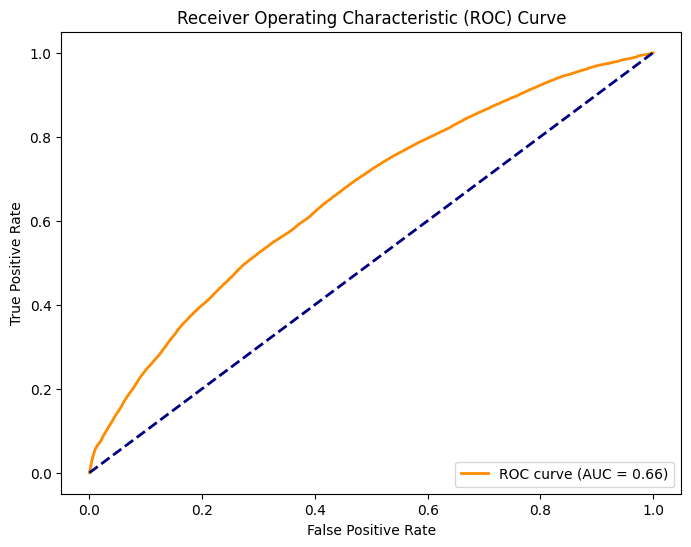

Test Set Results:
Baseline Log Loss (test): 0.1553
Baseline ROC AUC (test): 0.5000
Model Log Loss (test): 0.1476
Model ROC AUC (test): 0.7037


In [10]:
model = create_model(data)

In [6]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

def cv(data: pd.DataFrame):
    categorical_features = ['os_id', 'country_id']

    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), categorical_features),
            ('interaction', PolynomialFeatures(degree=2, include_bias=False), categorical_features)
        ],
        remainder='passthrough'
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=10000, random_state=42, solver='liblinear', 
                                           penalty='l2', fit_intercept=False, verbose=2))
    ])

    param_grid = {
        'classifier__C': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
    }

    tscv = TimeSeriesSplit(n_splits=3, test_size=2000000)

    grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, 
                               scoring={'neg_log_loss': 'neg_log_loss', 'roc_auc': 'roc_auc'}, 
                               n_jobs=1, verbose=3, refit='roc_auc')

    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred_val = best_model.predict(X_validate)
    y_prob_val = best_model.predict_proba(X_validate)[:, 1]

    print(f"Validation Log Loss: {log_loss(y_validate, y_prob_val):.4f}")
    print(f"Validation ROC AUC: {roc_auc_score(y_validate, y_prob_val):.4f}")
    print("Validation Classification Report:\n", classification_report(y_validate, y_pred_val))

    fpr, tpr, _ = roc_curve(y_validate, y_prob_val)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print("Test Set Results:")

    pred = np.ones_like(y_test) * y_test.mean()
    baseline = (y_test == 0).sum() / len(y_test)
    print(f"Baseline Log Loss (test): {log_loss(y_test, pred):.4f}")
    print(f"Baseline ROC AUC (test): {roc_auc_score(y_test, pred):.4f}")

    y_pred_test = best_model.predict(X_test)
    y_prob_test = best_model.predict_proba(X_test)[:, 1]

    accuracy_test = accuracy_score(y_test, y_pred_test)
    logloss_test = log_loss(y_test, y_prob_test)
    roc_auc_test = roc_auc_score(y_test, y_prob_test)

    print(f"Model Log Loss (test): {logloss_test:.4f}")
    print(f"Model ROC AUC (test): {roc_auc_test:.4f}")

    return best_model


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LibLinear]iter  1 act 1.211e+06 pre 1.028e+06 delta 3.024e-03 f 3.132e+06 |g| 8.272e+08 CG   1
cg reaches trust region boundary
iter  2 act 4.474e+05 pre 3.629e+05 delta 4.671e-03 f 1.920e+06 |g| 2.529e+08 CG   2
cg reaches trust region boundary
iter  3 act 2.762e+05 pre 2.298e+05 delta 7.173e-03 f 1.473e+06 |g| 1.039e+08 CG   2
cg reaches trust region boundary
iter  4 act 1.619e+05 pre 1.380e+05 delta 1.115e-02 f 1.197e+06 |g| 4.021e+07 CG   2
cg reaches trust region boundary
iter  5 act 1.068e+05 pre 9.298e+04 delta 1.832e-02 f 1.035e+06 |g| 1.458e+07 CG   2
cg reaches trust region boundary
iter  6 act 6.440e+04 pre 8.633e+04 delta 1.693e-02 f 9.280e+05 |g| 8.212e+06 CG   2
cg reaches trust region boundary
iter  7 act 6.961e+04 pre 6.415e+04 delta 2.650e-02 f 8.636e+05 |g| 3.074e+07 CG   2
cg reaches trust region boundary
iter  8 act 4.956e+04 pre 5.088e+04 delta 4.998e-02 f 7.940e+05 |g| 7.494e+06 CG   2
cg reaches trust r

cg reaches trust region boundary
iter 13 act 1.764e+04 pre 1.786e+04 delta 1.345e-01 f 9.026e+05 |g| 1.933e+06 CG   5
iter 14 act 5.991e+03 pre 5.584e+03 delta 1.345e-01 f 8.850e+05 |g| 2.155e+06 CG   4
cg reaches trust region boundary
iter 15 act 1.397e+04 pre 1.411e+04 delta 2.245e-01 f 8.790e+05 |g| 7.088e+05 CG   5
cg reaches trust region boundary
iter 16 act 2.195e+04 pre 2.210e+04 delta 5.078e-01 f 8.650e+05 |g| 1.169e+06 CG   6
cg reaches trust region boundary
iter 17 act 3.505e+04 pre 3.456e+04 delta 1.144e+00 f 8.430e+05 |g| 2.710e+05 CG   6
cg reaches trust region boundary
iter 18 act -4.983e+03 pre 3.294e+04 delta 5.310e-01 f 8.080e+05 |g| 3.054e+05 CG   9
cg reaches trust region boundary
iter 18 act 1.629e+04 pre 1.782e+04 delta 5.407e-01 f 8.080e+05 |g| 3.054e+05 CG   9
iter 19 act 3.170e+02 pre 3.074e+02 delta 5.407e-01 f 7.917e+05 |g| 2.883e+06 CG   2
cg reaches trust region boundary
iter 20 act 1.909e+03 pre 1.692e+04 delta 2.704e-01 f 7.914e+05 |g| 2.215e+05 CG   9
ite

cg reaches trust region boundary
iter  6 act 6.440e+03 pre 8.633e+03 delta 1.693e-02 f 9.280e+04 |g| 8.212e+05 CG   2
cg reaches trust region boundary
iter  7 act 6.961e+03 pre 6.415e+03 delta 2.650e-02 f 8.636e+04 |g| 3.074e+06 CG   2
cg reaches trust region boundary
iter  8 act 4.956e+03 pre 5.088e+03 delta 4.998e-02 f 7.940e+04 |g| 7.494e+05 CG   2
cg reaches trust region boundary
iter  9 act 5.392e+03 pre 5.030e+03 delta 7.472e-02 f 7.444e+04 |g| 2.565e+05 CG   3
cg reaches trust region boundary
iter 10 act 2.798e+03 pre 2.600e+03 delta 8.109e-02 f 6.905e+04 |g| 3.308e+05 CG   4
cg reaches trust region boundary
iter 11 act 1.586e+03 pre 1.684e+03 delta 8.109e-02 f 6.625e+04 |g| 3.256e+05 CG   4
cg reaches trust region boundary
iter 12 act 2.087e+03 pre 2.005e+03 delta 1.220e-01 f 6.466e+04 |g| 2.871e+05 CG   5
cg reaches trust region boundary
iter 13 act 1.215e+03 pre 1.234e+03 delta 1.336e-01 f 6.258e+04 |g| 1.321e+05 CG   5
iter 14 act 4.203e+02 pre 3.916e+02 delta 1.336e-01 f 6.

cg reaches trust region boundary
iter  5 act 2.014e+04 pre 1.754e+04 delta 1.831e-02 f 1.951e+05 |g| 2.750e+06 CG   2
cg reaches trust region boundary
iter  6 act 1.216e+04 pre 1.632e+04 delta 1.692e-02 f 1.750e+05 |g| 1.554e+06 CG   2
cg reaches trust region boundary
iter  7 act 1.314e+04 pre 1.210e+04 delta 2.646e-02 f 1.628e+05 |g| 5.811e+06 CG   2
cg reaches trust region boundary
iter  8 act 9.350e+03 pre 9.588e+03 delta 5.015e-02 f 1.497e+05 |g| 1.417e+06 CG   2
cg reaches trust region boundary
iter  9 act 1.017e+04 pre 9.483e+03 delta 7.476e-02 f 1.403e+05 |g| 4.796e+05 CG   3
cg reaches trust region boundary
iter 10 act 5.261e+03 pre 4.903e+03 delta 8.096e-02 f 1.302e+05 |g| 6.298e+05 CG   4
cg reaches trust region boundary
iter 11 act 3.001e+03 pre 3.188e+03 delta 8.096e-02 f 1.249e+05 |g| 6.174e+05 CG   4
cg reaches trust region boundary
iter 12 act 3.944e+03 pre 3.779e+03 delta 1.228e-01 f 1.219e+05 |g| 5.422e+05 CG   5
cg reaches trust region boundary
iter 13 act 2.285e+03 p

cg reaches trust region boundary
iter 12 act 3.020e+02 pre 2.904e+02 delta 1.219e-01 f 9.328e+03 |g| 4.167e+04 CG   5
cg reaches trust region boundary
iter 13 act 1.764e+02 pre 1.786e+02 delta 1.345e-01 f 9.026e+03 |g| 1.934e+04 CG   5
iter 14 act 5.988e+01 pre 5.581e+01 delta 1.345e-01 f 8.850e+03 |g| 2.154e+04 CG   4
cg reaches trust region boundary
iter 15 act 1.397e+02 pre 1.411e+02 delta 2.246e-01 f 8.790e+03 |g| 7.085e+03 CG   5
cg reaches trust region boundary
iter 16 act 2.193e+02 pre 2.212e+02 delta 5.096e-01 f 8.650e+03 |g| 1.169e+04 CG   6
cg reaches trust region boundary
iter 17 act 3.490e+02 pre 3.457e+02 delta 1.124e+00 f 8.431e+03 |g| 9.725e+03 CG   6
iter 18 act 2.396e+00 pre 2.318e+00 delta 1.124e+00 f 8.082e+03 |g| 3.639e+04 CG   1
cg reaches trust region boundary
iter 19 act -3.905e+01 pre 3.263e+02 delta 5.295e-01 f 8.079e+03 |g| 3.215e+03 CG   9
cg reaches trust region boundary
iter 19 act 1.652e+02 pre 1.794e+02 delta 5.513e-01 f 8.079e+03 |g| 3.215e+03 CG   9
ite

iter 49 act 1.931e-01 pre 1.887e-01 delta 3.286e-01 f 9.846e+03 |g| 3.755e+02 CG   8
cg reaches trust region boundary
iter 50 act 2.408e+00 pre 2.413e+00 delta 3.538e-01 f 9.846e+03 |g| 4.347e+01 CG  16
iter 51 act 1.547e-01 pre 1.534e-01 delta 3.538e-01 f 9.843e+03 |g| 1.093e+04 CG   1
iter 52 act 5.480e-02 pre 5.481e-02 delta 3.538e-01 f 9.843e+03 |g| 1.776e+02 CG   7
[CV 3/3] END classifier__C=0.01; neg_log_loss: (test=-0.116) roc_auc: (test=0.660) total time= 2.8min
[LibLinear]iter  1 act 1.211e+03 pre 1.028e+03 delta 3.024e-03 f 3.132e+03 |g| 8.272e+05 CG   1
cg reaches trust region boundary
iter  2 act 4.474e+02 pre 3.629e+02 delta 4.671e-03 f 1.920e+03 |g| 2.529e+05 CG   2
cg reaches trust region boundary
iter  3 act 2.762e+02 pre 2.298e+02 delta 7.173e-03 f 1.473e+03 |g| 1.039e+05 CG   2
cg reaches trust region boundary
iter  4 act 1.619e+02 pre 1.380e+02 delta 1.115e-02 f 1.197e+03 |g| 4.021e+04 CG   2
cg reaches trust region boundary
iter  5 act 1.068e+02 pre 9.298e+01 delta 

cg reaches trust region boundary
iter 36 act -2.769e+00 pre 1.074e+00 delta 5.276e-02 f 7.605e+02 |g| 2.041e+01 CG  12
cg reaches trust region boundary
iter 36 act 3.545e-01 pre 4.476e-01 delta 5.276e-02 f 7.605e+02 |g| 2.041e+01 CG   8
iter 37 act 1.031e-01 pre 1.034e-01 delta 5.276e-02 f 7.602e+02 |g| 1.020e+02 CG   8
cg reaches trust region boundary
iter 38 act 1.361e-01 pre 1.344e-01 delta 9.157e-02 f 7.601e+02 |g| 2.147e+01 CG   9
cg reaches trust region boundary
iter 39 act 2.009e-01 pre 2.294e-01 delta 1.037e-01 f 7.600e+02 |g| 1.488e+01 CG  11
iter 40 act 2.217e-02 pre 2.211e-02 delta 1.037e-01 f 7.598e+02 |g| 4.815e+02 CG   2
cg reaches trust region boundary
iter 41 act 2.263e-01 pre 2.190e-01 delta 1.581e-01 f 7.597e+02 |g| 1.568e+01 CG  10
cg reaches trust region boundary
iter 42 act 2.485e-01 pre 2.479e-01 delta 2.167e-01 f 7.595e+02 |g| 2.728e+01 CG  14
iter 43 act 8.827e-03 pre 8.875e-03 delta 2.167e-01 f 7.593e+02 |g| 9.732e+01 CG   2
cg reaches trust region boundary
ite

iter 25 act 3.958e-04 pre 3.958e-04 delta 5.355e-01 f 5.527e+01 |g| 3.201e-01 CG  14
[CV 1/3] END classifier__C=0.0001; neg_log_loss: (test=-0.118) roc_auc: (test=0.623) total time=  34.1s
[LibLinear]iter  1 act 1.748e+02 pre 1.484e+02 delta 3.024e-03 f 4.518e+02 |g| 1.194e+05 CG   1
cg reaches trust region boundary
iter  2 act 6.455e+01 pre 5.235e+01 delta 4.671e-03 f 2.770e+02 |g| 3.649e+04 CG   2
cg reaches trust region boundary
iter  3 act 3.984e+01 pre 3.316e+01 delta 7.172e-03 f 2.125e+02 |g| 1.498e+04 CG   2
cg reaches trust region boundary
iter  4 act 2.336e+01 pre 1.990e+01 delta 1.115e-02 f 1.726e+02 |g| 5.800e+03 CG   2
cg reaches trust region boundary
iter  5 act 1.540e+01 pre 1.341e+01 delta 1.831e-02 f 1.493e+02 |g| 2.103e+03 CG   2
cg reaches trust region boundary
iter  6 act 9.304e+00 pre 1.245e+01 delta 1.695e-02 f 1.339e+02 |g| 1.185e+03 CG   2
cg reaches trust region boundary
iter  7 act 1.003e+01 pre 9.239e+00 delta 2.652e-02 f 1.246e+02 |g| 4.422e+03 CG   2
cg reac

iter 17 act 6.905e-03 pre 6.698e-03 delta 2.067e-01 f 6.031e+00 |g| 5.477e+00 CG   5
iter 18 act 1.112e-02 pre 1.108e-02 delta 2.067e-01 f 6.024e+00 |g| 1.137e+00 CG   9
iter 19 act 4.020e-06 pre 4.014e-06 delta 2.067e-01 f 6.013e+00 |g| 7.537e-01 CG   2
iter 20 act 1.751e-04 pre 1.750e-04 delta 2.067e-01 f 6.013e+00 |g| 6.992e-02 CG  11
[CV 1/3] END classifier__C=1e-05; neg_log_loss: (test=-0.128) roc_auc: (test=0.580) total time=  26.4s
[LibLinear]iter  1 act 1.748e+01 pre 1.484e+01 delta 3.024e-03 f 4.518e+01 |g| 1.194e+04 CG   1
cg reaches trust region boundary
iter  2 act 6.455e+00 pre 5.235e+00 delta 4.671e-03 f 2.770e+01 |g| 3.649e+03 CG   2
cg reaches trust region boundary
iter  3 act 3.984e+00 pre 3.316e+00 delta 7.172e-03 f 2.125e+01 |g| 1.498e+03 CG   2
cg reaches trust region boundary
iter  4 act 2.336e+00 pre 1.990e+00 delta 1.115e-02 f 1.726e+01 |g| 5.800e+02 CG   2
cg reaches trust region boundary
iter  5 act 1.540e+00 pre 1.341e+00 delta 1.831e-02 f 1.493e+01 |g| 2.103e

cg reaches trust region boundary
iter  9 act 7.034e-02 pre 6.616e-02 delta 6.811e-02 f 1.075e+00 |g| 4.743e+00 CG   3
cg reaches trust region boundary
iter 10 act 3.628e-02 pre 3.357e-02 delta 7.684e-02 f 1.005e+00 |g| 3.758e+00 CG   5
cg reaches trust region boundary
iter 11 act 1.951e-02 pre 2.008e-02 delta 8.248e-02 f 9.684e-01 |g| 3.346e+00 CG   5
iter 12 act 5.736e-03 pre 5.423e-03 delta 8.248e-02 f 9.489e-01 |g| 2.309e+00 CG   3
cg reaches trust region boundary
iter 13 act 8.153e-03 pre 8.027e-03 delta 8.503e-02 f 9.431e-01 |g| 6.825e-01 CG   5
iter 14 act 9.651e-04 pre 9.633e-04 delta 8.503e-02 f 9.350e-01 |g| 5.662e-01 CG   7
iter 15 act 8.225e-05 pre 8.250e-05 delta 8.503e-02 f 9.340e-01 |g| 4.391e-02 CG   8
iter 16 act 3.847e-06 pre 3.848e-06 delta 8.503e-02 f 9.339e-01 |g| 8.313e-03 CG   9
[CV 2/3] END classifier__C=1e-06; neg_log_loss: (test=-0.137) roc_auc: (test=0.567) total time=  32.0s
[LibLinear]iter  1 act 2.283e+00 pre 1.939e+00 delta 3.024e-03 f 5.904e+00 |g| 1.560e

iter 11 act 3.711e+02 pre 3.943e+02 delta 8.092e-02 f 1.544e+04 |g| 7.600e+04 CG   4
cg reaches trust region boundary
iter 12 act 4.855e+02 pre 4.651e+02 delta 1.229e-01 f 1.506e+04 |g| 6.678e+04 CG   5
cg reaches trust region boundary
iter 13 act 2.833e+02 pre 2.886e+02 delta 1.344e-01 f 1.458e+04 |g| 2.963e+04 CG   5
iter 14 act 9.809e+01 pre 9.144e+01 delta 1.344e-01 f 1.430e+04 |g| 3.512e+04 CG   4
cg reaches trust region boundary
iter 15 act 2.189e+02 pre 2.207e+02 delta 2.079e-01 f 1.420e+04 |g| 1.151e+04 CG   5
cg reaches trust region boundary
iter 16 act 3.327e+02 pre 3.390e+02 delta 4.305e-01 f 1.398e+04 |g| 2.039e+04 CG   6
iter 17 act 2.845e+00 pre 2.764e+00 delta 4.305e-01 f 1.365e+04 |g| 4.838e+04 CG   1
cg reaches trust region boundary
iter 18 act 4.354e+02 pre 4.452e+02 delta 6.787e-01 f 1.364e+04 |g| 4.621e+03 CG   6
iter 19 act 8.590e+01 pre 7.896e+01 delta 6.787e-01 f 1.321e+04 |g| 1.566e+04 CG   5
cg reaches trust region boundary
iter 20 act 3.701e+02 pre 3.889e+02 d

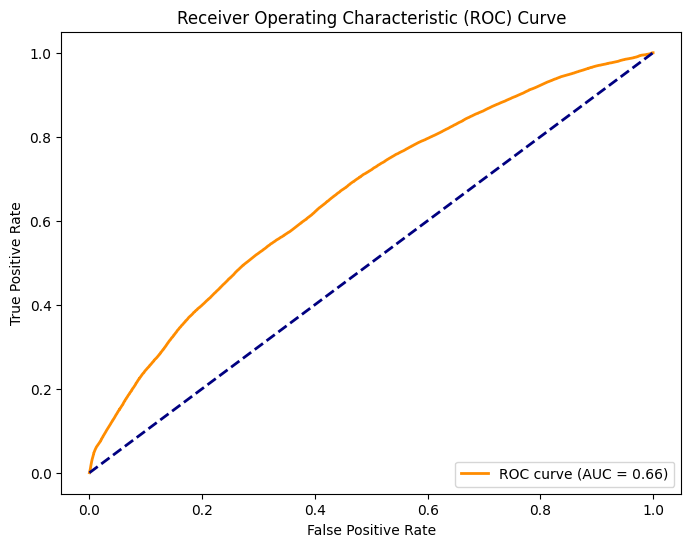

Test Set Results:
Baseline Log Loss (test): 0.1553
Baseline ROC AUC (test): 0.5000
Model Log Loss (test): 0.1476
Model ROC AUC (test): 0.7040


In [7]:
best_model = cv(data)

Результаты: 
1. Побили бейзлайн 
Baseline Log Loss (test): 0.1553
Baseline ROC AUC (test): 0.5000
Model Log Loss (test): 0.1476
Model ROC AUC (test): 0.7040
2. Лучшие параметры: 
Best parameters: {'classifier__C': 0.01}

# HW_2

1. Добавим oaid_hash в наши данные 
2. проведем feature_engineering 

In [3]:
data = pd.read_csv('data.csv')
# уберем фичи, которые не используются для задания 
unused_features = ['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1',
                   'coeff_sum0', 'coeff_sum1']
data.drop(columns=unused_features, inplace=True)
data.head()

def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # 1 - убираем impressions
    data.drop(columns='impressions', inplace=True)
    
    # 2 - убираем дубликаты 
    data.drop_duplicates(inplace=True)

    # 3 - преобразовываем date_time
    data['date_time'] = pd.to_datetime(data['date_time'])
    
    #UPD3: избавимся от выброса в данных
    first_date = data['date_time'].dt.date.min()
    data = data[data['date_time'].dt.date != first_date]
    print("Убедимся, что в значениях нет выброса", data['date_time'].dt.date.unique(), 
         data['date_time'].dt.date.min(), data['date_time'].dt.date.max(), sep='\n')


    data['week_day'] = data['date_time'].dt.dayofweek + 1
    data['quarter_of_day'] = (data['date_time'].dt.hour // 6) + 1
    data['hour_day'] = (data['date_time'].dt.hour).astype('int64')
    
    # В zone_id есть значения, которые встречаются больше 2M раз, а есть значения, которые 
    # встречаются лишь единожды. Объединим редкие значения в одно, чтобы модель не считывала эти значения 
    # как выбросы и могла лучше обощаться в будущем. Пусть этим значением будет "-1"
    threshold = 20000 
    value_counts_zone_id = data['zone_id'].value_counts()
    rare_values = value_counts_zone_id[value_counts_zone_id <= threshold].index
    data['zone_id'] = data['zone_id'].apply(lambda x: -1 if x in rare_values else x)
    
    # UPD: добавим интеракции 
    data['campaign_clicks_country_id'] = data['campaign_clicks'] / data.groupby('country_id')['campaign_clicks'].transform('sum')
    data['campaign_clicks_zone_id'] = data['campaign_clicks'] / data.groupby('zone_id')['campaign_clicks'].transform('sum')

    

    return data


data = feature_engineering(data)
data.head()

Убедимся, что в значениях нет выброса
[datetime.date(2021, 9, 27) datetime.date(2021, 9, 26)
 datetime.date(2021, 9, 29) datetime.date(2021, 9, 30)
 datetime.date(2021, 9, 28) datetime.date(2021, 10, 1)
 datetime.date(2021, 10, 2)]
2021-09-26
2021-10-02


/var/folders/kk/l1f5jw9n0hv45nw_rrhz85th0000gn/T/ipykernel_73657/2643392647.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['week_day'] = data['date_time'].dt.dayofweek + 1
/var/folders/kk/l1f5jw9n0hv45nw_rrhz85th0000gn/T/ipykernel_73657/2643392647.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['quarter_of_day'] = (data['date_time'].dt.hour // 6) + 1
/var/folders/kk/l1f5jw9n0hv45nw_rrhz85th0000gn/T/ipykernel_73657/2643392647.py:27: SettingWithCopyWarning: 
A value is trying to be set on

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks,week_day,quarter_of_day,hour_day,campaign_clicks_country_id,campaign_clicks_zone_id
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1,1,1,0,0.000000,0.000000
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1,7,4,22,0.000000,0.000000
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1,7,4,23,0.000003,0.000021
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,1,1,1,0,0.000000,0.000000
4,2021-09-27 00:06:21,-1,4,4778985830203613115,0,1,0,1,1,1,0,0.000000,0.000000


In [4]:
# https://github.com/wngaw/blog/blob/master/xlearn_example/src/utils.py

import json
import math
from tqdm import tqdm

def _convert_to_ffm(path, df, type, target, numerics, categories, features, encoder):
    # Flagging categorical and numerical fields
    print('convert_to_ffm - START')
    for x in numerics:
        if(x not in encoder['catdict']):
            encoder['catdict'][x] = 0
    for x in categories:
        if(x not in encoder['catdict']):
            encoder['catdict'][x] = 1

    nrows = df.shape[0]
    with open(path + str(type) + "_ffm.txt", "w") as text_file:

        # Looping over rows to convert each row to libffm format
        for n, r in enumerate(tqdm(range(nrows))):
            datastring = ""
            datarow = df.iloc[r].to_dict()
            datastring += str(int(datarow[target]))  # Set Target Variable here

            # For numerical fields, we are creating a dummy field here
            for i, x in enumerate(encoder['catdict'].keys()):
                if(encoder['catdict'][x] == 0):
                    # Not adding numerical values that are nan
                    if math.isnan(datarow[x]) is not True:
                        datastring = datastring + " "+str(i)+":" + str(i)+":" + str(datarow[x])
                else:

                    # For a new field appearing in a training example
                    if(x not in encoder['catcodes']):
                        encoder['catcodes'][x] = {}
                        encoder['currentcode'] += 1
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    # For already encoded fields
                    elif(datarow[x] not in encoder['catcodes'][x]):
                        encoder['currentcode'] += 1
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    code = encoder['catcodes'][x][datarow[x]]
                    datastring = datastring + " "+str(i)+":" + str(int(code))+":1"

            datastring += '\n'
            text_file.write(datastring)

    return encoder


In [13]:
import datetime
data["date_time"] = pd.to_datetime(data["date_time"])
data['date'] = data.date_time.dt.date

train_data = data[data["date"] < datetime.date(2021, 10, 1)]
val_data = data[data["date"] == datetime.date(2021, 10, 1)]
test_data = data[data["date"] == datetime.date(2021, 10, 2)]
print(len(train_data), len(val_data), len(test_data))

test_data.drop(columns=['date', 'date_time'], inplace=True)
train_data.drop(columns=['date', 'date_time'], inplace=True)
val_data.drop(columns=['date', 'date_time'], inplace=True)


11993681 1637919 2121766


/var/folders/kk/l1f5jw9n0hv45nw_rrhz85th0000gn/T/ipykernel_73657/2275269091.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(columns=['date', 'date_time'], inplace=True)
/var/folders/kk/l1f5jw9n0hv45nw_rrhz85th0000gn/T/ipykernel_73657/2275269091.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns=['date', 'date_time'], inplace=True)
/var/folders/kk/l1f5jw9n0hv45nw_rrhz85th0000gn/T/ipykernel_73657/2275269091.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [14]:
num_features = ["campaign_clicks"]
cat_features = ["zone_id", "banner_id", "oaid_hash", "os_id", "country_id"]
features = num_features + cat_features


In [15]:
# Initialise fields and variables encoder
encoder = {"currentcode": len(num_features),  # Unique index for each numerical field or categorical variables
           "catdict": {},  # Dictionary that stores numerical and categorical variables
           "catcodes": {}}  # Dictionary that stores index for each categorical variables per categorical field


In [16]:
encoder = _convert_to_ffm('./', train_data, 'train3', 'clicks',
                          num_features,
                          cat_features,
                          features,
                          encoder)

encoder = _convert_to_ffm('./', val_data, 'val3', 'clicks',
                          num_features,
                          cat_features,
                          features,
                          encoder)

encoder = _convert_to_ffm('./', test_data, 'test3', 'clicks',
                          num_features,
                          cat_features,
                          features,
                          encoder)

convert_to_ffm - START


100%|████████████████████████████| 11993681/11993681 [10:54<00:00, 18333.54it/s]


convert_to_ffm - START


100%|██████████████████████████████| 1637919/1637919 [01:28<00:00, 18550.40it/s]


convert_to_ffm - START


100%|██████████████████████████████| 2121766/2121766 [01:56<00:00, 18258.73it/s]


In [5]:
import xlearn as xl


ModuleNotFoundError: No module named 'keras.layers.core'

In [ ]:
import xlearn as xl
from sklearn.model_selection import ParameterGrid

params = {
    'task': ['binary'],
    'lr': [0.15],
    'lambda':[0.01, 0.001, 0.0005, 0.0001],
    'k': [4],
    'metric': ['auc'],
    'epoch': [35],
    'opt': ['adagrad']
}


